In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

import mnist_data_utils 
import mnist_vae_lib
import vae_training_lib

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as f

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Load data

In [2]:
data_dir = './mnist_data/'
propn_sample = 0.05

In [3]:
train_set, test_set = mnist_data_utils.get_moving_mnist_dataset(data_dir, propn_sample)

In [4]:
batchsize = 5

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [5]:
for batch_idx, d in enumerate(train_loader):
    data_train = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [6]:
slen = data_train['image'].shape[-1]

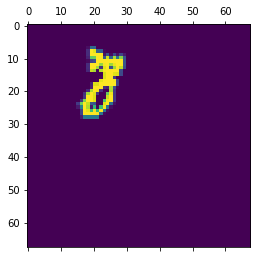

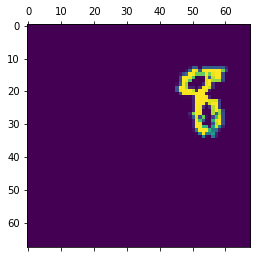

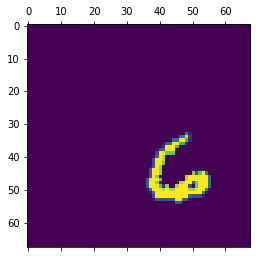

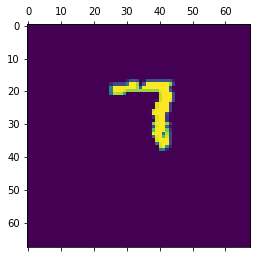

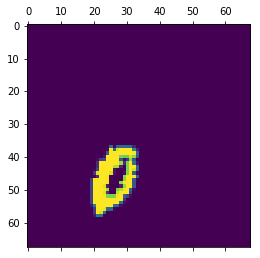

In [7]:
for i in range(batchsize): 
    plt.matshow(data_train['image'][i, 0, :, :])

# Define VAE

In [8]:
image = data_train['image']
pixel_2d = data_train['pixel_2d']

In [9]:
moving_mnist_vae = mnist_vae_lib.MovingHandwritingVAE()

In [10]:
moving_mnist_vae.get_rb_loss(image)

(tensor(27858.8770), tensor(13076.1348))

In [11]:
# Check padding and cropping functions

In [12]:
mnist_slen = 28
cropped_images = moving_mnist_vae.crop_image(image, pixel_2d)

In [13]:
cropped_images.shape

torch.Size([5, 1, 29, 29])

In [14]:
repadded_images = moving_mnist_vae.pad_image(cropped_images, pixel_2d)

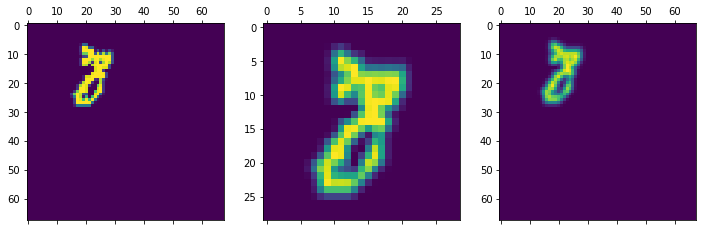

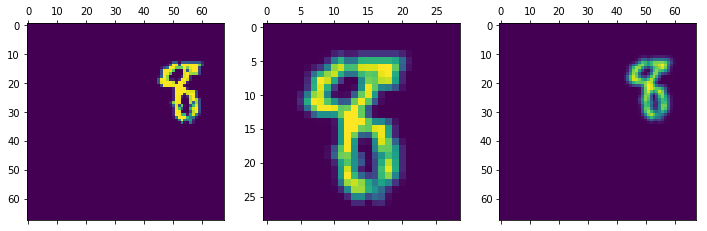

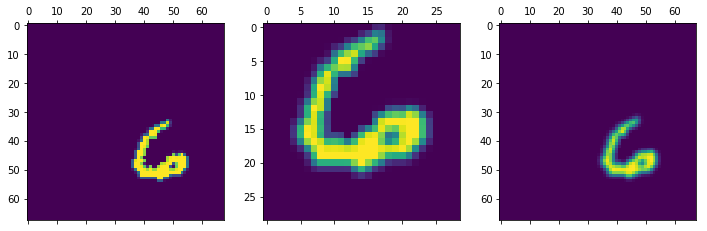

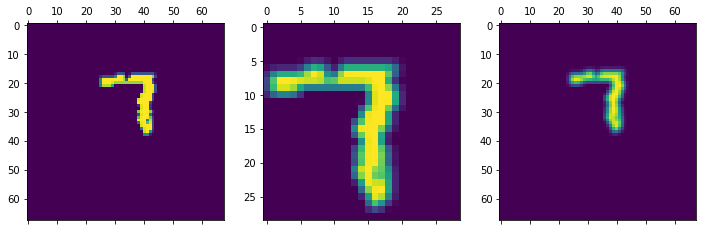

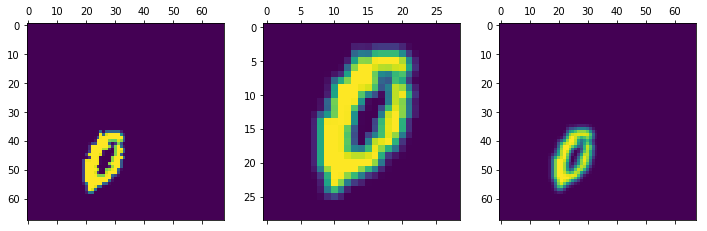

In [15]:
for i in range(batchsize): 
        
    _, axarr = plt.subplots(1, 3, figsize=(12, 12))
    
    axarr[0].matshow(image[i, 0, :, :])
    axarr[1].matshow(cropped_images[i, 0, :, :])
    axarr[2].matshow(repadded_images[i, 0, :, :])

In [16]:
image.shape

torch.Size([5, 1, 68, 68])

In [17]:
cropped_images.shape

torch.Size([5, 1, 29, 29])

In [18]:
repadded_images.shape

torch.Size([5, 1, 68, 68])

In [19]:
# Checking 1d - 2d conversion 

In [20]:
pixel_1d = moving_mnist_vae._pixel_1d_from_2d(pixel_2d)

In [21]:
pixel_2d_re = mnist_data_utils.pixel_1d_to_2d(moving_mnist_vae.full_slen,
                                    padding = 0,
                                    pixel_1d = pixel_1d)

In [22]:
assert np.all(pixel_2d == pixel_2d_re)

In [23]:
class_weights = moving_mnist_vae._get_class_weights_from_pixel_2d(pixel_2d)

In [24]:
assert np.all(pixel_1d == torch.argmax(class_weights, dim = 1))

In [25]:
class_weights.sum(1, keepdim = True)

tensor([[ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.]])

# Check training goes through

In [23]:
weight_decay = 1e-6
lr = 0.001

optimizer = optim.Adam([
                {'params': moving_mnist_vae.parameters(),
                'lr': lr,
                'weight_decay': weight_decay}])

In [24]:
vae_training_lib.train_vae(moving_mnist_vae, train_loader, test_loader, optimizer,
                outfile = './test',
                n_epoch = 5, print_every = 2, save_every = 2, 
                set_true_loc = True)

KeyboardInterrupt: 